In [48]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.synthetic_array_beamformer_processor import SyntheticArrayBeamformerProcessor
from mmwave_radar_processing.plotting.plotter_synthetic_array_data import PlotterSyntheticArrayData
from mmwave_radar_processing.plotting.movies_synthetic_array_data import MovieGeneratorSyntheticArrayData
from mmwave_radar_processing.detectors.CFAR import CaCFAR_1D,CaCFAR_2D

## Initializing the processor, dataset, and radar configuration

In [49]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR_2_sr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [50]:
#load the dataset
dataset_name = "RadSAR_2_CPSL"
dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

found 133 radar samples
found 133 lidar samples
found 133 camera samples
found 133 imu (orientation only) samples
found 133imu (full data) samples
found 133 vehicle velocity samples


In [51]:
cfar_2d = CaCFAR_2D(
    num_guard_cells=np.array([2,5]),
    num_training_cells=np.array([3,15]),
    false_alarm_rate=0.0001,
    resp_border_cells=np.array([5,5]),
    mode="full"
)

processor = SyntheticArrayBeamformerProcessor(
    config_manager=cfg_manager,
    cfar=cfar_2d,
    az_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-35,stop=35,num=80
                 )),
    el_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-60,
                    stop=60,
                    num=16
                ))
)

synthetic_array_plotter = PlotterSyntheticArrayData(
    config_manager=cfg_manager,
    processor_SABF=processor,
    min_vel=0.4
)

movie_generator = MovieGeneratorSyntheticArrayData(
    cpsl_dataset=dataset,
    plotter=synthetic_array_plotter,
    processor=processor,
    temp_dir_path="~/Downloads/syntheticArrays"
)

alpha: 9.318284672014343 (mag), 19.38671947875081 dB
found temp dir: /home/david/Downloads/syntheticArrays
clearing temp directory /home/david/Downloads/syntheticArrays


## Accessing the dataset at a particular and generating the array geometry

In [52]:
idx = 30
vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
processor._generate_array_geometries(
    vels=np.array([-vel,0,0])
)
print("Array geometry generated with velocity: {:0.2f}".format(vel))

Array geometry generated with velocity: 0.43


In [53]:
#get the adc cube (indexed by rx, adc sample, chirp)
adc_cube = dataset.get_radar_data(idx)

#reshape it to be indexed by (adc sample, rx, chirp)
adc_cube_transposed = np.transpose(adc_cube,axes=(1,0,2))

#reshape the adc cube to be (adc sample, rx * chirps)
adc_cube_reshaped = np.reshape(
    adc_cube_transposed,
    (adc_cube_transposed.shape[0],-1),
    order="F"
)

## Processing the array signal
Here, we start by generating a plot of the FFTs before any beam stearing

Text(0.5, 0, 'Range Bin Index')

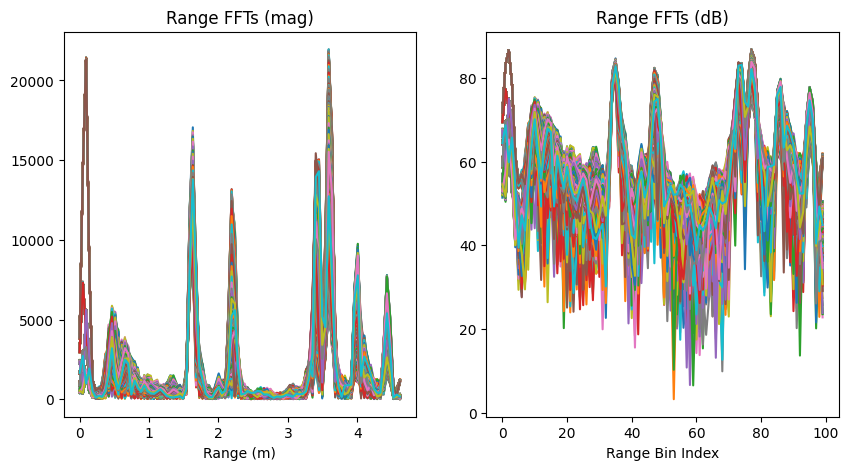

In [54]:
#compute the window
window = np.reshape(np.hanning(processor.num_range_bins),(processor.num_range_bins,-1))

windowed_signal = window * adc_cube_reshaped

freq_resps = np.fft.fft(windowed_signal,axis=0)

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
#plot the magnitude
axs[0].plot(processor.range_bins,np.abs(freq_resps))
axs[0].set_title("Range FFTs (mag)")
axs[0].set_xlabel("Range (m)")

#plot on log scale
axs[1].plot(20*(np.log10(np.abs(freq_resps))))
axs[1].set_title("Range FFTs (dB)")
axs[1].set_xlabel("Range Bin Index")

Idxs with least variance: [35 34 71 76 77 95 36]


Text(0.5, 1.0, 'Range FFTs (dB)')

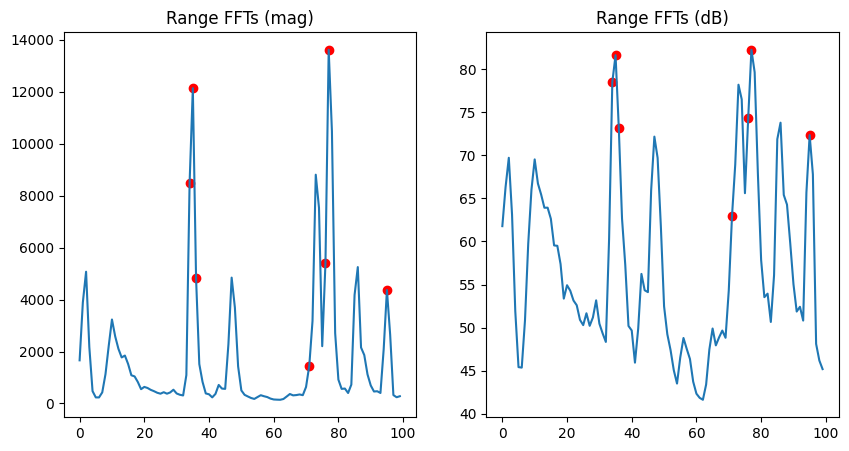

In [55]:
# compute the average response values (dB)
rng_ffts_dB = 20*(np.log10(np.abs(freq_resps)))
rng_ffts_dB_avg = np.average(rng_ffts_dB,axis=1)

#compute the average response values (mag)
rng_ffts_mag = np.abs(freq_resps)
rng_ffts_mag_avg = np.average(rng_ffts_mag,axis=1)

rng_bin_vars = np.var(rng_ffts_dB,axis=1)

N_smallest_var = 7
#TODO: Get these peaks from a 1D CFAR detector
least_var_idxs = np.argsort(rng_bin_vars)[:N_smallest_var]
avg_dB_vals = rng_ffts_dB_avg[least_var_idxs]
avg_mag_vals = rng_ffts_mag_avg[least_var_idxs]

print("Idxs with least variance: {}".format(least_var_idxs))

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
#plot the magnitude
axs[0].plot(rng_ffts_mag_avg)
axs[0].scatter(least_var_idxs,avg_mag_vals,c="red",label="Least Var.")
axs[0].set_title("Range FFTs (mag)")

#plot on log scale
axs[1].plot(rng_ffts_dB_avg)
axs[1].scatter(least_var_idxs,avg_dB_vals,c="red",label="Least Var.")
axs[1].set_title("Range FFTs (dB)")


In [56]:
#get the index with the least amount of variance
rng_bin_idx = least_var_idxs[0]


Text(0, 0.5, 'El angle (deg)')

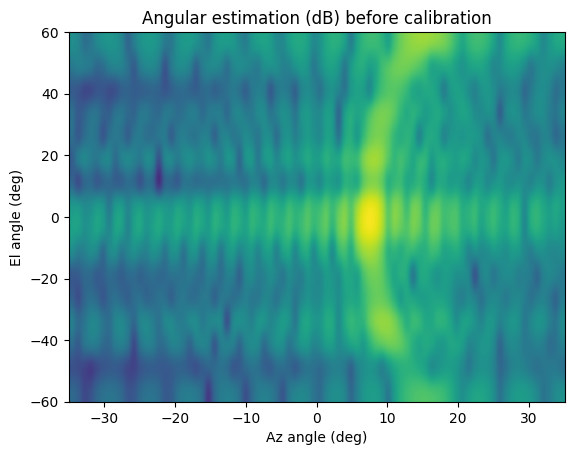

In [57]:
#Angular response at the specific range bin
# rng_bin_idx = 10
resp = np.zeros(
    shape=(processor.az_angle_bins_rad.shape[0],
           processor.el_angle_bins_rad.shape[0]),
    dtype=complex
)

for az_angle_idx in range(processor.az_angle_bins_rad.shape[0]):
    for el_angle_idx in range(processor.el_angle_bins_rad.shape[0]):

        steering_vector = processor.d[:,az_angle_idx,el_angle_idx]

        shifts = np.exp(
            1j * 2 * np.pi * \
            (steering_vector @ processor.p_reshaped) / processor.lambda_m)

        resp[az_angle_idx,el_angle_idx] = np.matmul(shifts,freq_resps[rng_bin_idx])

resp_dB = 20*np.log10(np.abs(resp))

fig,ax=plt.subplots()
ax.imshow(
        np.flip(resp_dB.transpose(),axis=0),
        extent=[
                np.rad2deg(processor.az_angle_bins_rad[0]),
                np.rad2deg(processor.az_angle_bins_rad[-1]),
                np.rad2deg(processor.el_angle_bins_rad[0]),
                np.rad2deg(processor.el_angle_bins_rad[-1])
            ],
        aspect='auto',
        interpolation="gaussian"
)
ax.set_title("Angular estimation (dB) before calibration")
ax.set_xlabel("Az angle (deg)")
ax.set_ylabel("El angle (deg)")

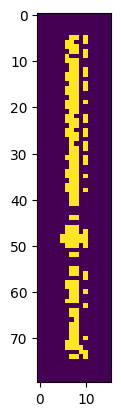

In [58]:
det_idxs,threshs = cfar_2d.compute(
    signal=resp
)

plt.imshow(det_idxs)

# ax.scatter(x_coords,y_coords,
#             c=color,
#             s=5.0,
#             alpha=0.75)

